## **# 2019 Presidential Election : Public Opinion Tweet Sentiment Analysis**

Given the 2019 presidential election's tweet data of public opinion, this project consist of :
1. Experimenting with varieties of preprocessing and vectorization technique
2. Testing the Random Forest & LSTM algorithm
3. Optimizing (Hyperparameter Tuning)
4. Evaluating and conclude which algorithms is the best performing

# **1. Initialization**

## **1.1 Load Libraries**

In [1]:
!pip install Sastrawi

In [2]:
# Load libraries
import os
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm
from ast import literal_eval
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [3]:
# Set pandas progress bar
tqdm.pandas()

## **1.2 Read Dataset**

In [4]:
dataset_token = 'GHSAT0AAAAAACFAZZWZGG2JL4MHWMWHK7MIZFTETYA'
dataset_url = 'https://raw.githubusercontent.com/Arietrif/Projects-NLP-Sentiment-Analysis/main/tweet.csv?token='+dataset_token

raw_data = pd.read_csv(dataset_url)
raw_data.columns = ['row_num', 'sentimen', 'tweet']
raw_data.head(5)

,row_num,sentimen,tweet
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_num   1815 non-null   int64 
 1   sentimen  1815 non-null   object
 2   tweet     1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB


In [6]:
raw_data['sentimen'].value_counts()

positif    612
netral     607
negatif    596
Name: sentimen, dtype: int64

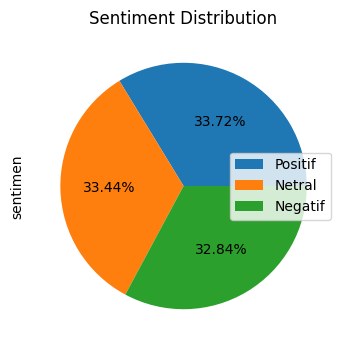

In [8]:
import matplotlib.pyplot as plt

raw_data['sentimen'].value_counts().plot.pie(figsize=(4,4),title="Sentiment Distribution",labels=['','',''],autopct='%1.2f%%')
labels=["Positif","Netral","Negatif"]
plt.legend(labels,loc=5)
plt.gca().set_aspect('equal')


In [9]:
data = raw_data.copy()

# **2. Natural Language Text Preprocessing**

## **2.1 Text Cleaning**

In [10]:
import re
import string

def clean_text(text):
    # Menghapus username Twitter (@username)
    text = re.sub(r'@\w+', '', text)
    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Menghapus karakter non-alfanumerik dan tanda baca
    text = re.sub(r'[^\w\s]', '', text)
    # Menghapus karakter berulang
    text = re.sub(r'(.)\1+', r'\1\1', text)
    # Mengubah ke lowercase
    text = text.lower()

    return text

def remove(tweet):
    # Remove mention
    tweet = re.sub("@[A-Za-z0-9_]+", "", tweet)
    # Remove stock market tickers like $GE
    tweet = re.sub(r'$\w*', '', tweet)
    # Remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'^rt[\s]+', '', tweet)
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'^https[\s]+', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'%', '', tweet)
    # Remove commas
    tweet = re.sub(r',', '', tweet)
    # Remove numbers
    tweet = re.sub('[0-9]+', '', tweet)
    tweet = re.sub(r':', '', tweet)
    # Remove space
    tweet = tweet.strip()
    # Remove double space}
    tweet = re.sub('\s+', ' ', tweet)
    # Remove number
    tweet = re.sub(r'\d+', '', tweet)
    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Cleaning text
    cleaned_tweet = clean_text(tweet)
    return cleaned_tweet

# apply remove and clean_text function on 'tweet' and save in 'tweet_clean'
data['tweet_clean'] = data['tweet'].apply(lambda x: remove(x.lower()))
data['tweet_clean'].head(5)

0    kata indonesia tidak dihargai bangsa asing ber...
1    batuan langka tasbih jokowi hadiah dari habib ...
2    di era jokowi ekonomi indonesia semakin baik i...
3    bagi sumatera selatan asian games berdampak pd...
4    negara kita ngutang buat bngun infrastruktur y...
Name: tweet_clean, dtype: object

## **2.2 Stopword Removal**

In [11]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### **2.2.1 Traditional Stopword**

In [12]:
import re
import pandas as pd

def remove_stopwords(text):
    stopwords = ['yg','ðŸ','ðÿœ',"yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah']  # Ganti dengan stopwords tradisional sesuai kebutuhan

    # Menghapus karakter non-alfabet dan mengubah teks menjadi huruf kecil
    processed_text = re.sub(r'[^a-zA-Z]', ' ', text.lower())

    # Memisahkan kata-kata dalam teks
    words = processed_text.split()

    # Menghapus stopwords dari teks
    filtered_words = [word for word in words if word not in stopwords]

    # Menggabungkan kembali kata-kata yang telah di-filter
    filtered_text = ' '.join(filtered_words)

    return filtered_text

# Menerapkan fungsi remove_stopwords pada kolom 'tweet_clean'
filtered_text = data['tweet_clean'].apply(remove_stopwords)

# Menampilkan DataFrame hasil
print(filtered_text)


0       kata indonesia tidak dihargai bangsa asing ber...
1       batuan langka tasbih jokowi hadiah dari habib ...
2       di era jokowi ekonomi indonesia semakin baik i...
3       bagi sumatera selatan asian games berdampak pd...
4       negara kita ngutang buat bngun infrastruktur y...
                              ...                        
1810    negarawan sejati sll bangga dan mengedepankan ...
1811    hrs ceramah di damai indonesiaku perekonomian ...
1812    mari bangun bangsa mendukung perekonomian nega...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_clean, Length: 1815, dtype: object


### **2.2.2 Sastrawi Stopword**

In [13]:
!pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import re

def preprocess_text(text):
    # Buat instance dari StopWordRemoverFactory
    factory = StopWordRemoverFactory()
    stopword_remover = factory.create_stop_word_remover()

    # Menghapus karakter non-alfanumerik dan mengubah ke huruf kecil
    text = re.sub(r'\W+', ' ', text.lower())

    # Menghapus stopwords dari teks menggunakan Sastrawi
    text_tanpa_stopword = stopword_remover.remove(text)

    return text_tanpa_stopword

data['tweet_sw'] = filtered_text.apply(preprocess_text)

print(data['tweet_sw'])

0       kata indonesia dihargai bangsa asing berita pa...
1       batuan langka tasbih jokowi hadiah habib luthf...
2       era jokowi ekonomi indonesia semakin baik indo...
3       sumatera selatan asian games berdampak pd ekon...
4       negara ngutang buat bngun infrastruktur udah d...
                              ...                        
1810    negarawan sejati sll bangga mengedepankan harg...
1811    hrs ceramah damai indonesiaku perekonomian mak...
1812    bangun bangsa mendukung perekonomian negara be...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_sw, Length: 1815, dtype: object


## **2.3 Text Normalization**

### **2.3.1 Lemmazation**

In [14]:
import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatization (text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)
data['tweet_clean'] = data['tweet_sw'].apply(lemmatization)

In [15]:
data['tweet_clean']

0       kata indonesia dihargai bangsa ase berita past...
1       batuan langka tasbih jokowi hadiah habib luthf...
2       era jokowi ekonomi indonesia semakin baik indo...
3       sumatera selatan asian game berdampak pd ekono...
4       negara ngutang buat bngun infrastruktur udah d...
                              ...                        
1810    negarawan sejati sll bangga mengedepankan harg...
1811    hrs ceramah damai indonesiaku perekonomian mak...
1812    bangun bangsa mendukung perekonomian negara be...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_clean, Length: 1815, dtype: object

## **2.4 Text Tokenization**

### **2.4.1 Word Tokenization**

In [16]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Fungsi untuk tokenisasi kata
def tokenize_words(text):
    words = word_tokenize(text)
    return words

# Tokenisasi kata
data['tweet_token_words'] = data['tweet_clean'].apply(tokenize_words)
print("\nTokenisasi kata:")
print(data['tweet_token_words'])


Tokenisasi kata:
0       [kata, indonesia, dihargai, bangsa, ase, berit...
1       [batuan, langka, tasbih, jokowi, hadiah, habib...
2       [era, jokowi, ekonomi, indonesia, semakin, bai...
3       [sumatera, selatan, asian, game, berdampak, pd...
4       [negara, ngutang, buat, bngun, infrastruktur, ...
                              ...                        
1810    [negarawan, sejati, sll, bangga, mengedepankan...
1811    [hrs, ceramah, damai, indonesiaku, perekonomia...
1812    [bangun, bangsa, mendukung, perekonomian, nega...
1813    [bantu, majukan, perekonomian, bangsa, bersama...
1814    [pak, mengubah, cara, pandang, ekonomi, kini, ...
Name: tweet_token_words, Length: 1815, dtype: object


### **2.4.2 Sentence Tokenization**

In [17]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Fungsi untuk tokenisasi kalimat
def tokenize_sentences(text):
    sentences = sent_tokenize(text)
    return sentences

# Tokenisasi kalimat
data['tweet_token_sentences'] = data['tweet_clean'].apply(tokenize_sentences)
print("Tokenisasi kalimat:")
print(data['tweet_token_sentences'])

Tokenisasi kalimat:
0       [kata indonesia dihargai bangsa ase berita pas...
1       [batuan langka tasbih jokowi hadiah habib luth...
2       [era jokowi ekonomi indonesia semakin baik ind...
3       [sumatera selatan asian game berdampak pd ekon...
4       [negara ngutang buat bngun infrastruktur udah ...
                              ...                        
1810    [negarawan sejati sll bangga mengedepankan har...
1811    [hrs ceramah damai indonesiaku perekonomian ma...
1812    [bangun bangsa mendukung perekonomian negara b...
1813    [bantu majukan perekonomian bangsa bersama pak...
1814    [pak mengubah cara pandang ekonomi kini semua ...
Name: tweet_token_sentences, Length: 1815, dtype: object


## **2.5 Word2Vec**

### **2.5.1 CBOW**

In [18]:
import gensim
from gensim.models import Word2Vec

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [19]:
clean_data = data['tweet_clean'].apply(gensim.utils.simple_preprocess)

In [20]:
w2v_model = Word2Vec(vector_size=W2V_SIZE,
                     window=W2V_WINDOW,
                     min_count=W2V_MIN_COUNT,
                     workers=8)

In [21]:
w2v_model.build_vocab(clean_data)

In [22]:
words = list(w2v_model.wv.key_to_index.keys())
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 599


In [23]:
%%time
w2v_model.train(clean_data, total_examples=len(clean_data), epochs=W2V_EPOCH)

CPU times: user 1.95 s, sys: 44.3 ms, total: 1.99 s
Wall time: 2.03 s


(485412, 1029728)

In [24]:
# Membuat objek Word2Vec (contoh)
sentences = [tweet.split() for tweet in data['tweet_clean']]
w2v_model = Word2Vec(sentences=sentences, min_count=1)

# Membuat kolom baru di DataFrame untuk menampung hasil append
data['tweet_w2v_model'] = data['tweet_clean'].apply(lambda x: w2v_model.wv[x.split()[0]] if len(x.split()) > 0 else [])

# Menampilkan DataFrame
print("tweet_w2v_model kalimat:")
print(data['tweet_w2v_model'])

tweet_w2v_model kalimat:
0       [-0.038407058, 0.10917249, 0.11146068, 0.01596...
1       [0.0010882557, 0.0036358547, -0.002190964, 0.0...
2       [-0.03957938, 0.10544908, 0.1207639, 0.0277250...
3       [-0.0020750375, 0.018362768, 0.028419644, -0.0...
4       [-0.08168821, 0.25851193, 0.2980598, 0.0452845...
                              ...                        
1810    [0.0010867115, -0.0025075201, 0.0032208513, 0....
1811    [-0.0067334427, 0.05805434, 0.055827755, 0.020...
1812    [-0.0091988295, 0.05304953, 0.05904097, 0.0075...
1813    [-0.003021156, 0.009553221, 0.014545442, -0.00...
1814    [-0.098471, 0.30839503, 0.3258351, 0.05865368,...
Name: tweet_w2v_model, Length: 1815, dtype: object


In [25]:
similar_words = w2v_model.wv.most_similar("ekonomi")
similar_words

[('rakyat', 0.9996875524520874),
 ('jokowi', 0.999643087387085),
 ('indonesia', 0.9995438456535339),
 ('harga', 0.9994696378707886),
 ('prabowo', 0.999464213848114),
 ('negara', 0.99945467710495),
 ('pak', 0.9994531273841858),
 ('mau', 0.9994474649429321),
 ('game', 0.9994322657585144),
 ('pajak', 0.9994081258773804)]

# **3. Feature Engineering**

In [26]:
# Load libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [60]:
# Define feature and target data
feature = data['tweet_token_sentences'].values
target  = data['sentimen'].values

In [61]:
# Transform string to label
encoder = LabelEncoder()
target_encoder = encoder.fit_transform(target)

In [62]:
# Split dataset into training-testing
X_train, X_test, y_train, y_test = train_test_split(feature, target_encoder, test_size = 0.2, random_state = 1)

In [63]:
# Check dimension
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1452,), (363,), (1452,), (363,))

In [64]:
X_train_str = [' '.join(tokens) for tokens in X_train]
X_test_str = [' '.join(tokens) for tokens in X_test]

In [65]:
# Transform text data into vector data
embedding = CountVectorizer()
embedding.fit(X_train_str)
embedding.fit(X_test_str)

CountVectorizer()

In [67]:
## Apply on train-test
X_train_vec = embedding.transform(X_train_str)
X_test_vec  = embedding.transform(X_test_str)

In [68]:
# Check dimension of text vectorized
X_train_vec.shape, X_test_vec.shape

((1452, 2539), (363, 2539))

# **4. Data Modeling**

In [71]:
# Load libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [72]:
# Set styling
plt.style.use("ggplot")

## **4.1 Random Forest Baseline**

In [73]:
# Define random forest model
model = RandomForestClassifier()

In [74]:
### Training model
model.fit(X_train_vec, y_train)

RandomForestClassifier()

In [75]:
### Evaluate model on train set
pred = model.predict(X_train_vec)
print(classification_report(y_train, pred, target_names = ['negatif', 'netral', 'positif']))

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00       479
      netral       1.00      1.00      1.00       480
     positif       1.00      1.00      1.00       493

    accuracy                           1.00      1452
   macro avg       1.00      1.00      1.00      1452
weighted avg       1.00      1.00      1.00      1452



In [76]:
### Evaluate model on test set
pred = model.predict(X_test_vec)
print(classification_report(y_test, pred, target_names = ['negatif', 'netral', 'positif']))

              precision    recall  f1-score   support

     negatif       0.58      0.73      0.64       117
      netral       0.61      0.51      0.56       127
     positif       0.56      0.51      0.54       119

    accuracy                           0.58       363
   macro avg       0.58      0.58      0.58       363
weighted avg       0.58      0.58      0.58       363



In [77]:
## Overview parameters baseline
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## **4.1.1 Random Forest Parameter Tuning**

In [78]:
## Define parameter used for tuning
params = {
    "n_estimators" : [100, 300, 500],
    "max_depth"    : [5, 10, 15],
    "max_features" : ['auto', 'sqrt'],
    "n_jobs"       : [-1]
}

In [79]:
## Define object
grid_search = GridSearchCV(
    estimator = model, param_grid = params,
    cv = 5, verbose = 1
)
grid_search.fit(X_train_vec, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 300, 500], 'n_jobs': [-1]},
             verbose=1)

In [80]:
## Get parameter tuning metrics and define the best parameters
metrics_tuning_forest = pd.DataFrame(grid_search.cv_results_)
metrics_tuning_forest = metrics_tuning_forest.sort_values('rank_test_score')
metrics_tuning_forest.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,1.926889,0.269729,0.128123,0.020978,15,sqrt,500,-1,"{'max_depth': 15, 'max_features': 'sqrt', 'n_e...",0.615120,0.580756,0.596552,0.548276,0.555172,0.579175,0.025010,1
14,1.974570,0.425489,0.138267,0.023381,15,auto,500,-1,"{'max_depth': 15, 'max_features': 'auto', 'n_e...",0.584192,0.570447,0.589655,0.568966,0.575862,0.577824,0.007966,2
8,2.148470,0.716042,0.131695,0.018662,10,auto,500,-1,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",0.597938,0.567010,0.596552,0.558621,0.568966,0.577817,0.016245,3
7,1.280404,0.381593,0.102348,0.026995,10,auto,300,-1,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",0.615120,0.584192,0.593103,0.541379,0.555172,0.577794,0.026481,4
11,1.562080,0.249029,0.115615,0.012263,10,sqrt,500,-1,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.601375,0.563574,0.593103,0.541379,0.568966,0.573679,0.021503,5


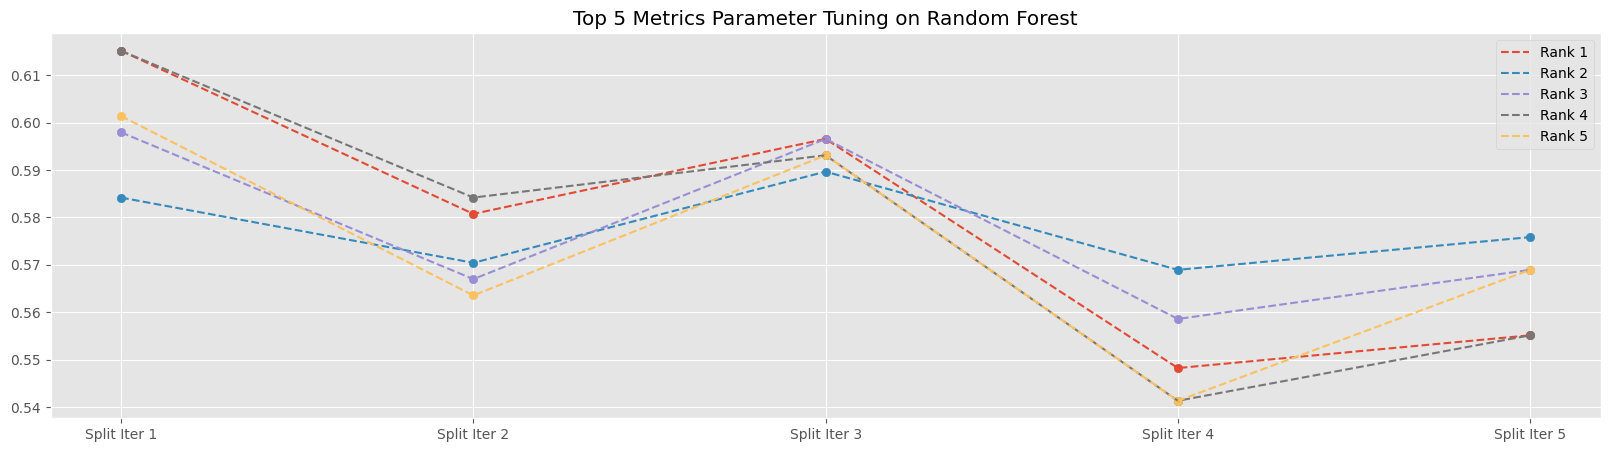

In [81]:
### Visualize metrics and params used
plt.figure(figsize = (20, 5))
for idx in range(5):
    plt.plot(list(range(0, 5)), metrics_tuning_forest.iloc[idx, 9:14], label = f"Rank {idx + 1}", linestyle = "--")
    plt.scatter(list(range(0, 5)), metrics_tuning_forest.iloc[idx, 9:14])
plt.legend()
plt.title("Top 5 Metrics Parameter Tuning on Random Forest")
plt.xticks(list(range(5)), list(map(lambda x: f"Split Iter {x + 1}", range(5))))
plt.show()

In [82]:
### Get Best Parameters
grid_search.best_params_

{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 500, 'n_jobs': -1}

In [83]:
# Define random forest model
model = RandomForestClassifier(max_depth = 15, max_features = "auto", n_estimators = 500, n_jobs = -1)

In [84]:
### Training model
model.fit(X_train_vec, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=15, max_features='auto', n_estimators=500,
                       n_jobs=-1)

In [85]:
### Evaluate model on train set
pred = model.predict(X_train_vec)
print(classification_report(y_train, pred, target_names = ['negatif', 'netral', 'positif']))

              precision    recall  f1-score   support

     negatif       0.91      0.88      0.90       479
      netral       0.80      0.91      0.85       480
     positif       0.95      0.86      0.90       493

    accuracy                           0.88      1452
   macro avg       0.89      0.88      0.88      1452
weighted avg       0.89      0.88      0.88      1452



In [86]:
### Evaluate model on test set
pred = model.predict(X_test_vec)
print(classification_report(y_test, pred, target_names = ['negatif', 'netral', 'positif']))

              precision    recall  f1-score   support

     negatif       0.60      0.76      0.67       117
      netral       0.59      0.54      0.56       127
     positif       0.60      0.50      0.55       119

    accuracy                           0.60       363
   macro avg       0.60      0.60      0.59       363
weighted avg       0.60      0.60      0.59       363



## **4.2 LSTM Baseline**

In [87]:
# Load libraries
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense,
    Dropout, GRU, Bidirectional
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [88]:
# Define max length
MAX_LENGTH = 250

In [89]:
## Preprocess text to vector using Tokenizer
embedding_tf = Tokenizer(num_words = 10_000)
embedding_tf.fit_on_texts(X_train)

X_train_embedding = embedding_tf.texts_to_sequences(X_train)
X_test_embedding  = embedding_tf.texts_to_sequences(X_test)

In [90]:
## Preprocess label into one-hot-encoder format
y_train_encoder = to_categorical(y_train)
y_test_encoder = to_categorical(y_test)

In [91]:
## Preprocess vectorized data from stemmed sentences using pad_sequences
X_train_pad = pad_sequences(X_train_embedding, maxlen = MAX_LENGTH)
X_test_pad  = pad_sequences(X_test_embedding, maxlen = MAX_LENGTH)

In [92]:
X_test_pad = X_train_pad[:363]
y_test_encoder = y_train_encoder[:363]

In [93]:
# Create LSTM models with defined parameters
def create_model_lstm(
    n_units_lstm: int = 64, max_words: int = 10_000,
    max_sequence: int = MAX_LENGTH, dropout_rate: float = 0.2,
    n_units_dense: int = 32, n_dense_layers: int = 2,
    output_dim: int = 250
    ):

    model = Sequential()

    model.add(Input(shape = [max_sequence]))
    model.add(Embedding(input_dim = max_words, output_dim = output_dim, input_length = max_sequence))
    model.add(Bidirectional(LSTM(n_units_lstm, return_sequences = False)))

    # model.add(GRU(n_units_lstm, return_sequences = False))
    # model.add(Dense(n_units_dense, activation = "relu"))

    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation = "softmax"))

    return model

In [94]:
# Configure defined model
model = create_model_lstm()

## Compile model with hyperparameters
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [95]:
## Overview architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 250)          2500000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              161280    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 2,661,667
Trainable params: 2,661,667
Non-trainable params: 0
_________________________________________________________________


In [96]:
# Define custom callbacks
class OwnCallbacks(tf.keras.callbacks.Callback):

    def __init__(self, threshold = 0.95):
        super(OwnCallbacks, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [97]:
# Training model
history = model.fit(
    X_train_pad, y_train_encoder,
    batch_size = 16, epochs = 100,
    validation_data = (X_test_pad, y_test_encoder),
    callbacks = [OwnCallbacks()]
)

Epoch 1/100
91/91 [==============================] - 45s 447ms/step - loss: 1.1037 - accuracy: 0.3375 - val_loss: 1.0911 - val_accuracy: 0.3664
Epoch 2/100
91/91 [==============================] - 36s 399ms/step - loss: 1.0646 - accuracy: 0.4787 - val_loss: 0.8939 - val_accuracy: 0.8044
Epoch 3/100
91/91 [==============================] - 35s 385ms/step - loss: 0.4154 - accuracy: 0.9470 - val_loss: 0.0235 - val_accuracy: 0.9972


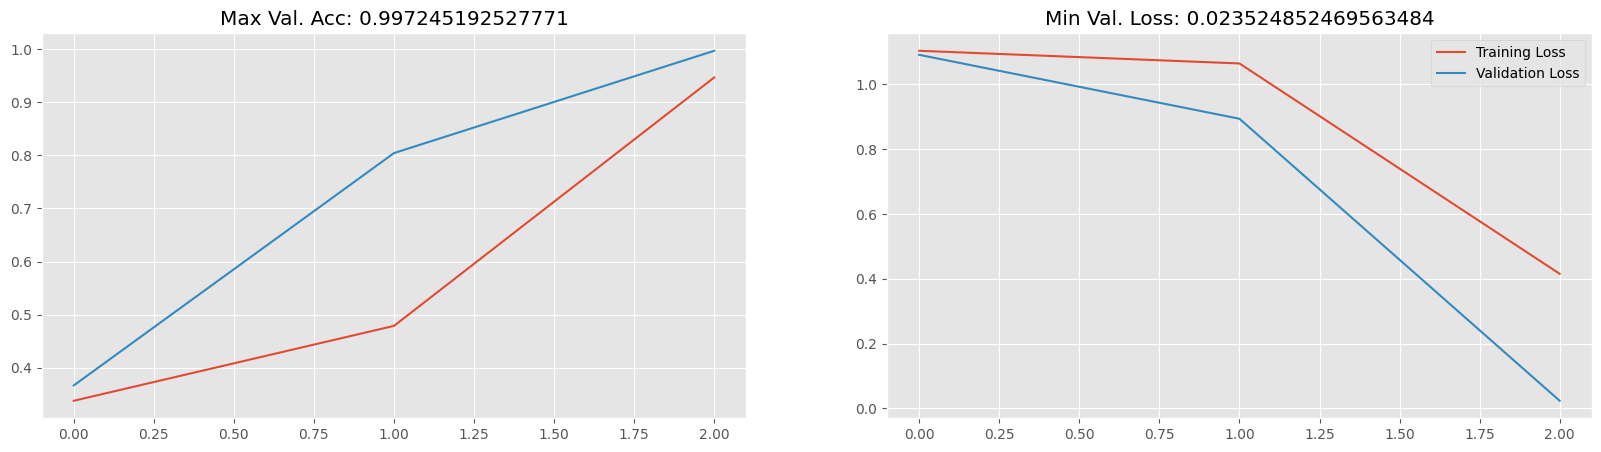

In [98]:
# Visualize plot training and validation
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
epochs = range(len(history.history['loss']))

ax[0].plot(epochs, history.history['accuracy'], label = "Training Accuracy")
ax[0].plot(epochs, history.history['val_accuracy'], label = "Validation Accuracy")
ax[0].set_title(f"Max Val. Acc: {max(history.history['val_accuracy'])}")

ax[1].plot(epochs, history.history['loss'], label = "Training Loss")
ax[1].plot(epochs, history.history['val_loss'], label = "Validation Loss")
ax[1].set_title(f"Min Val. Loss: {min(history.history['val_loss'])}")

plt.legend()
plt.show()

In [99]:
### Evaluate model on train set
pred = model.predict(X_train_pad).argmax(axis = 1)
true = y_train_encoder.argmax(axis = 1)
print(classification_report(true, pred, target_names = ['negatif', 'netral', 'positif']))

46/46 [==============================] - 8s 150ms/step
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00       479
      netral       1.00      0.99      1.00       480
     positif       1.00      1.00      1.00       493

    accuracy                           1.00      1452
   macro avg       1.00      1.00      1.00      1452
weighted avg       1.00      1.00      1.00      1452



In [100]:
### Evaluate model on test set
pred = model.predict(X_test_pad).argmax(axis = 1)
true = y_test_encoder.argmax(axis = 1)
print(classification_report(true, pred, target_names = ['negatif', 'netral', 'positif']))

12/12 [==============================] - 2s 125ms/step
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00       134
      netral       0.99      1.00      1.00       107
     positif       1.00      0.99      1.00       122

    accuracy                           1.00       363
   macro avg       1.00      1.00      1.00       363
weighted avg       1.00      1.00      1.00       363

